# Importação de Libs

In [436]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregamento do Dataset
carrega 'imoveis_aluguel_final.csv'

In [437]:
file_path = '../pipeline/imoveis_aluguel_final.csv'
df = pd.read_csv(file_path)

# Análise do Dataset

In [438]:
print("\nShape of the dataset:")
print(df.shape)

print("\nDataset information:")
df.info()

df.head()


Shape of the dataset:
(2530, 11)

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2530 entries, 0 to 2529
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   description     2530 non-null   object 
 1   address         0 non-null      float64
 2   property_type   2530 non-null   object 
 3   price           2530 non-null   float64
 4   size            2530 non-null   float64
 5   bedrooms        1764 non-null   float64
 6   bathrooms       0 non-null      float64
 7   parking_spaces  1205 non-null   float64
 8   contract_type   2530 non-null   object 
 9   latitude        1176 non-null   float64
 10  longitude       1176 non-null   float64
dtypes: float64(8), object(3)
memory usage: 217.5+ KB


,description,address,property_type,price,size,bedrooms,bathrooms,parking_spaces,contract_type,latitude,longitude
0,"SQSW 300 Bloco A, SUDOESTE, BRASILIA",NaN,apartamento,32000.0,560.0,4.0,NaN,4.0,aluguel,-15.790135,-47.916156
1,"Avenida Parque Águas Claras, NORTE, AGUAS CLARAS",NaN,apartamento,8389.0,164.0,4.0,NaN,3.0,aluguel,-15.831147,-48.015068
2,"SQSW 500, SUDOESTE, BRASILIA",NaN,apartamento,26000.0,178.0,4.0,NaN,3.0,aluguel,-15.802401,-47.926044
3,"CCSW 1, SUDOESTE, BRASILIA",NaN,kitnet,4900.0,26.0,1.0,NaN,1.0,aluguel,-15.796851,-47.927408
4,"Avenida Parque Águas Claras, NORTE, AGUAS CLARAS",NaN,apartamento,10150.0,162.0,4.0,NaN,3.0,aluguel,-15.831147,-48.015068


# Tratamento de Missing Values

In [439]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
description          0
address           2530
property_type        0
price                0
size                 0
bedrooms           766
bathrooms         2530
parking_spaces    1325
contract_type        0
latitude          1354
longitude         1354
dtype: int64


Nota-se que as colunas address e bathrooms possuem todos os valores nulos, portanto excluiremos essas colunas do dataset.

In [440]:
df.drop(columns=['address', 'bathrooms'], inplace=True)

Ainda, trataremos as colunas parking_spaces e bedrooms, para que os valores nulos sejam preenchidos, ao invés de serem excluídos, visto que essas colunas possuem uma quantidade razoável de valores nulos.

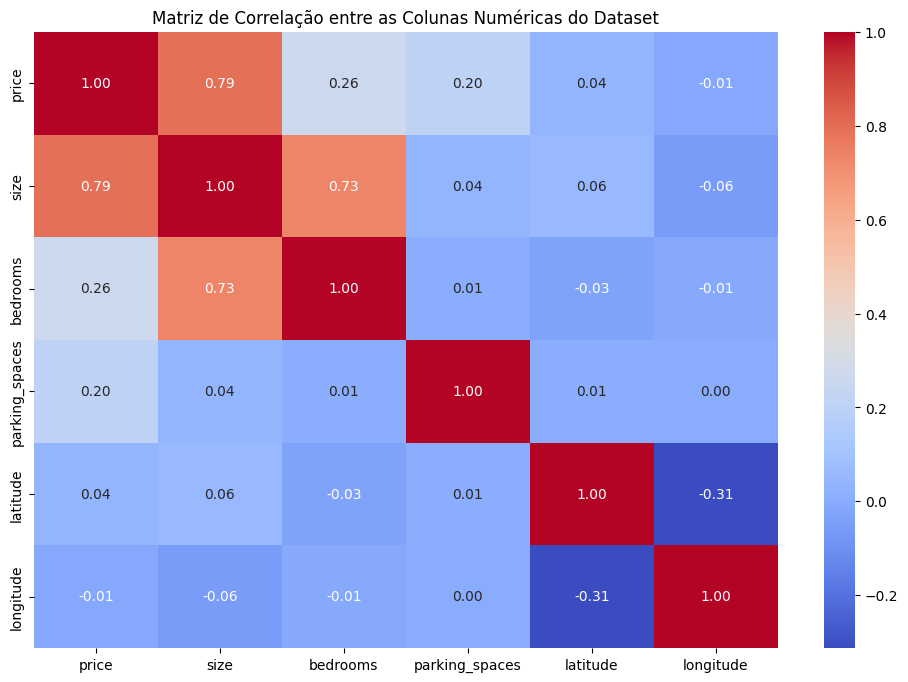

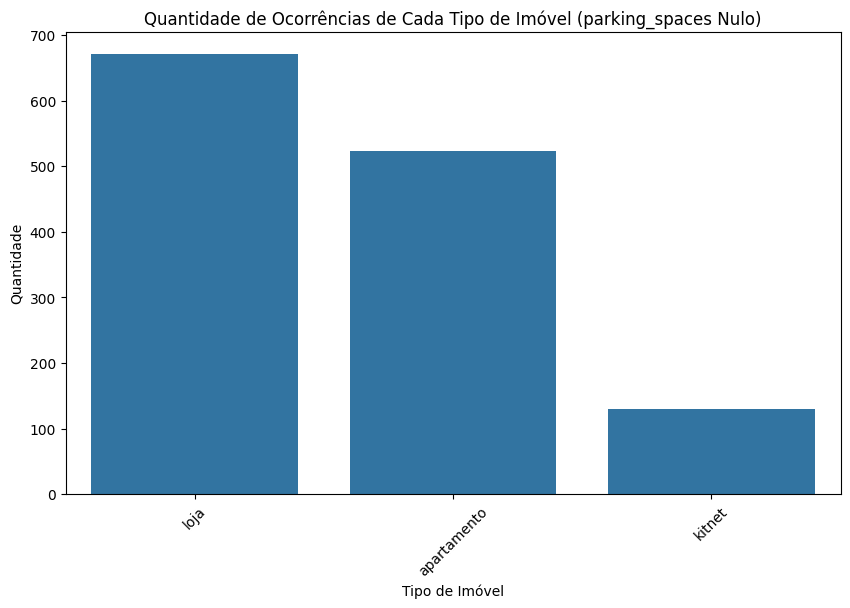

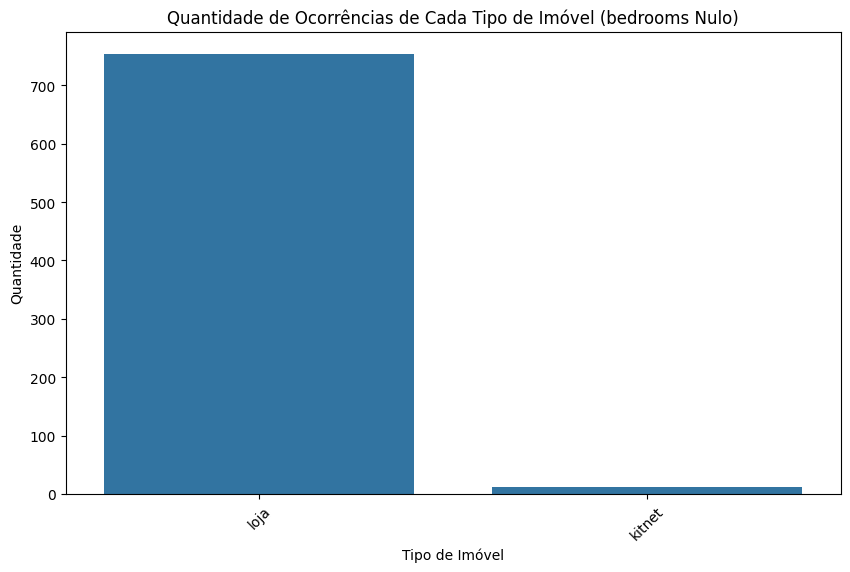

In [441]:
# Selecionar apenas colunas numéricas
numeric_columns = df.select_dtypes(include=['number'])

# Matriz de correlação entre colunas numéricas
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_columns.corr()  # Calcula a correlação entre colunas numéricas
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlação entre as Colunas Numéricas do Dataset")
plt.show()

# Gráfico para 'parking_spaces' nulo
if 'parking_spaces' in df.columns and 'property_type' in df.columns:
    parking_null = df[df['parking_spaces'].isnull()]
    plt.figure(figsize=(10, 6))
    sns.countplot(data=parking_null, x='property_type', order=parking_null['property_type'].value_counts().index)
    plt.title('Quantidade de Ocorrências de Cada Tipo de Imóvel (parking_spaces Nulo)')
    plt.xlabel('Tipo de Imóvel')
    plt.ylabel('Quantidade')
    plt.xticks(rotation=45)
    plt.show()

# Gráfico para 'bedrooms' nulo
if 'bedrooms' in df.columns and 'property_type' in df.columns:
    bedrooms_null = df[df['bedrooms'].isnull()]
    plt.figure(figsize=(10, 6))
    sns.countplot(data=bedrooms_null, x='property_type', order=bedrooms_null['property_type'].value_counts().index)
    plt.title('Quantidade de Ocorrências de Cada Tipo de Imóvel (bedrooms Nulo)')
    plt.xlabel('Tipo de Imóvel')
    plt.ylabel('Quantidade')
    plt.xticks(rotation=45)
    plt.show()

Com esta análise, fica claro que o Missing Data na coluna bedrooms está diretamente relacionado com o tipo de imóvel, sendo por dois possíveis motivos:

1 - Por ser uma **loja** 

2 - Por ser uma **kitnet** e, possivelmente, possui apenas 1 quarto.

Portanto, conclui-se que os dados faltantes em **parking_spaces** são do tipo **MCAR** (a matriz de correlação não indicou nenhum valor considerável para esta coluna, além de não ter sido indicada nenhuma relação com o tipo de imóvel), enquanto dados faltantes em **"bedrooms"** são do tipo **MNAR**.

Com isso trataremos da seguinte maneira:

**1 - parking_spaces:** Median Inputation - Além de ser robusto contra outliers, identificou-se que a mediana é 1, o que é coerente com o contexto da base de dados.

**2 - bedrooms:** Apenas iremos preencher da seguinte maneira: para kitnets o valor será 1, enquanto para lojas o valor será 0



*Refs*:

1 - https://www.datacamp.com/tutorial/techniques-to-handle-missing-data-values

2 - https://vtiya.medium.com/when-to-use-mean-median-mode-imputation-b0fd6be247db

In [442]:

if pd.api.types.is_numeric_dtype(df['parking_spaces']):
        # Calcular a mediana
        median_value = df['parking_spaces'].median()
        print(f"A mediana da coluna 'parking_spaces' é: {median_value}")
        
        # Preencher valores ausentes com a mediana
        df['parking_spaces'] = df['parking_spaces'].fillna(median_value)
        print("Valores ausentes preenchidos com a mediana.")
else:
        print("A coluna 'parking_spaces' contém valores não numéricos.")

A mediana da coluna 'parking_spaces' é: 1.0
Valores ausentes preenchidos com a mediana.


In [443]:
if 'bedrooms' in df.columns and 'property_type' in df.columns:
    # Preencher valores nulos na coluna 'bedrooms' com base no tipo de imóvel
    df.loc[(df['bedrooms'].isnull()) & (df['property_type'] == 'kitnet'), 'bedrooms'] = 1
    df.loc[(df['bedrooms'].isnull()) & (df['property_type'] == 'loja'), 'bedrooms'] = 0
    print("Valores nulos na coluna 'bedrooms' preenchidos com base no tipo de imóvel.")
else:
    print("As colunas 'bedrooms' ou 'property_type' não existem no DataFrame.")

Valores nulos na coluna 'bedrooms' preenchidos com base no tipo de imóvel.


Para Lat e Long testaremos o método de Multiple Inputation para valores nulos.

In [444]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

# Verificar se as colunas 'latitude' e 'longitude' existem no DataFrame
if 'latitude' in df.columns and 'longitude' in df.columns:
    # Selecionar as colunas relevantes para imputação
    columns_to_impute = ['latitude', 'longitude', 'price', 'size', 'bedrooms', 'parking_spaces']
    data_for_imputation = df[columns_to_impute]

    # Criar o imputador iterativo
    imputer = IterativeImputer(random_state=42)

    # Aplicar imputação múltipla
    imputed_data = imputer.fit_transform(data_for_imputation)

    # Substituir os valores imputados no DataFrame original
    df[['latitude', 'longitude']] = imputed_data[:, :2]

    print("Valores nulos nas colunas 'latitude' e 'longitude' foram preenchidos com imputação múltipla.")
else:
    print("As colunas 'latitude' e 'longitude' não existem no DataFrame.")

Valores nulos nas colunas 'latitude' e 'longitude' foram preenchidos com imputação múltipla.


In [445]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
description       0
property_type     0
price             0
size              0
bedrooms          0
parking_spaces    0
contract_type     0
latitude          0
longitude         0
dtype: int64


## One Hot Encoding
Aplicaremos o one hot encoding nas colunas property_type e contract_type


*Refs*:

1 - https://medium.com/%40vinodkumargr/08-data-encoding-in-machine-learning-different-data-encodings-onehotencoding-65f736d31ecf

In [446]:
# One-Hot Encoding para as colunas 'property_type' e 'contract_type'
if 'property_type' in df.columns and 'contract_type' in df.columns:
    # Aplicar One-Hot Encoding
    df = pd.get_dummies(df, columns=['property_type', 'contract_type'], drop_first=True)
    print("One-Hot Encoding aplicado nas colunas 'property_type' e 'contract_type'.")
else:
    print("As colunas 'property_type' ou 'contract_type' não existem no DataFrame.")

One-Hot Encoding aplicado nas colunas 'property_type' e 'contract_type'.


In [447]:
df.head()

,description,price,size,bedrooms,parking_spaces,latitude,longitude,property_type_kitnet,property_type_loja
0,"SQSW 300 Bloco A, SUDOESTE, BRASILIA",32000.0,560.0,4.0,4.0,-15.790135,-47.916156,False,False
1,"Avenida Parque Águas Claras, NORTE, AGUAS CLARAS",8389.0,164.0,4.0,3.0,-15.831147,-48.015068,False,False
2,"SQSW 500, SUDOESTE, BRASILIA",26000.0,178.0,4.0,3.0,-15.802401,-47.926044,False,False
3,"CCSW 1, SUDOESTE, BRASILIA",4900.0,26.0,1.0,1.0,-15.796851,-47.927408,True,False
4,"Avenida Parque Águas Claras, NORTE, AGUAS CLARAS",10150.0,162.0,4.0,3.0,-15.831147,-48.015068,False,False


# Analisando Price

In [448]:
# Analyze Property Prices
if 'price' in df.columns:
    print("Resumo estatistíco da coluna 'price':")
    print(df['price'].describe())

    # Identify outliers using the IQR method
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR))]
    print(f"Número de Outliers': {len(outliers)}")

Resumo estatistíco da coluna 'price':
count      2530.000000
mean       6484.017391
std       20018.155758
min         100.000000
25%        1505.000000
50%        2925.000000
75%        6000.000000
max      715000.000000
Name: price, dtype: float64
Número de Outliers': 236


# Outliers
Tratamento de outliers


In [449]:
# Valores mínimos e máximos para cada coluna numérica
numeric_columns = df.select_dtypes(include=['number']).columns

print("Valores mínimos e máximos para cada coluna numérica:")
for col in numeric_columns:
    min_value = df[col].min()
    max_value = df[col].max()
    print(f"Coluna: {col} | Mínimo: {min_value} | Máximo: {max_value}")

Valores mínimos e máximos para cada coluna numérica:
Coluna: price | Mínimo: 100.0 | Máximo: 715000.0
Coluna: size | Mínimo: 1.0 | Máximo: 11526.0
Coluna: bedrooms | Mínimo: 0.0 | Máximo: 5.0
Coluna: parking_spaces | Mínimo: 1.0 | Máximo: 4825.0
Coluna: latitude | Mínimo: -30.1257021 | Máximo: 22.0080329
Coluna: longitude | Mínimo: -99.0380483 | Máximo: -39.4493052


Percebe-se que algumas colunas possuem valores claramente errados, portanto excluiremos essas tuplas específicas e testaremos novamente

In [450]:
# Excluir a linha onde parking_spaces = 4825
if 'parking_spaces' in df.columns:
    df = df[df['parking_spaces'] != 4825]
    print("Linha onde 'parking_spaces' = 4825 foi excluída.")

# Excluir a linha onde size = 1
if 'size' in df.columns:
    df = df[df['size'] != 1]
    print("Linha onde 'size' = 1 foi excluída.")

Linha onde 'parking_spaces' = 4825 foi excluída.
Linha onde 'size' = 1 foi excluída.


In [451]:
# Valores mínimos e máximos para cada coluna numérica
numeric_columns = df.select_dtypes(include=['number']).columns

print("Valores mínimos e máximos para cada coluna numérica:")
for col in numeric_columns:
    min_value = df[col].min()
    max_value = df[col].max()
    print(f"Coluna: {col} | Mínimo: {min_value} | Máximo: {max_value}")

Valores mínimos e máximos para cada coluna numérica:
Coluna: price | Mínimo: 100.0 | Máximo: 715000.0
Coluna: size | Mínimo: 12.0 | Máximo: 11526.0
Coluna: bedrooms | Mínimo: 0.0 | Máximo: 5.0
Coluna: parking_spaces | Mínimo: 1.0 | Máximo: 257.0
Coluna: latitude | Mínimo: -30.1257021 | Máximo: 22.0080329
Coluna: longitude | Mínimo: -99.0380483 | Máximo: -39.4493052


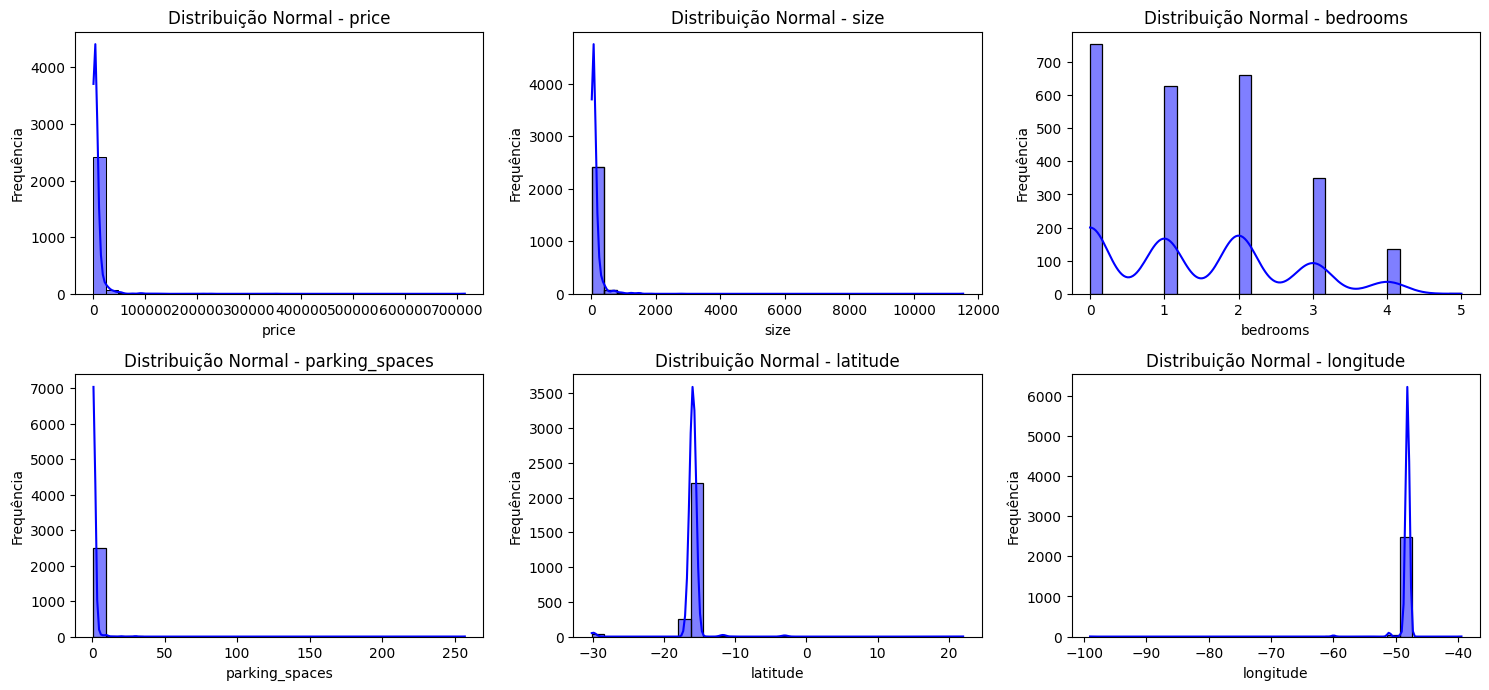

In [452]:
# Gráficos de distribuição normal para colunas numéricas
numeric_columns = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribuição Normal - {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.tight_layout()

plt.show()

In [453]:
# Contar valores maiores que 5 em parking_spaces
if 'parking_spaces' in df.columns:
    count_parking_spaces = (df['parking_spaces'] > 5).sum()
    print(f"Quantidade de valores maiores que 5 em 'parking_spaces': {count_parking_spaces}")

# Contar valores maiores que 500 em size
if 'size' in df.columns:
    count_size = (df['size'] > 500).sum()
    print(f"Quantidade de valores maiores que 1000 em 'size': {count_size}")

# Contar valores menores que 800 em price
if 'size' in df.columns:
    count_size = (df['price'] < 800).sum()
    print(f"Quantidade de valores menores que 1000 em 'size': {count_size}")

Quantidade de valores maiores que 5 em 'parking_spaces': 39
Quantidade de valores maiores que 1000 em 'size': 73
Quantidade de valores menores que 1000 em 'size': 100


Utilizaremos o **Quantile Based Flooring and Capping** para tratar Outliers

*Refs:*

1 - https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/#2e43

2 - https://franciscofoz.medium.com/como-tratar-outliers-sem-exclu%C3%AD-los-19dd5c1ba3e6

Tratando outliers na coluna: price
Outliers tratados na coluna price. Valores abaixo de 1000.0 foram substituídos por 1000.0, e valores acima de 12000.0 foram substituídos por 12000.0.
Tratando outliers na coluna: size
Outliers tratados na coluna size. Valores abaixo de 30.0 foram substituídos por 30.0, e valores acima de 213.0 foram substituídos por 213.0.
Tratando outliers na coluna: bedrooms
Outliers tratados na coluna bedrooms. Valores abaixo de 0.0 foram substituídos por 0.0, e valores acima de 3.0 foram substituídos por 3.0.
Tratando outliers na coluna: parking_spaces
Outliers tratados na coluna parking_spaces. Valores abaixo de 1.0 foram substituídos por 1.0, e valores acima de 2.0 foram substituídos por 2.0.
Tratando outliers na coluna: latitude
Outliers tratados na coluna latitude. Valores abaixo de -16.337876126988107 foram substituídos por -16.337876126988107, e valores acima de -15.759776957929965 foram substituídos por -15.759776957929965.
Tratando outliers na coluna: long

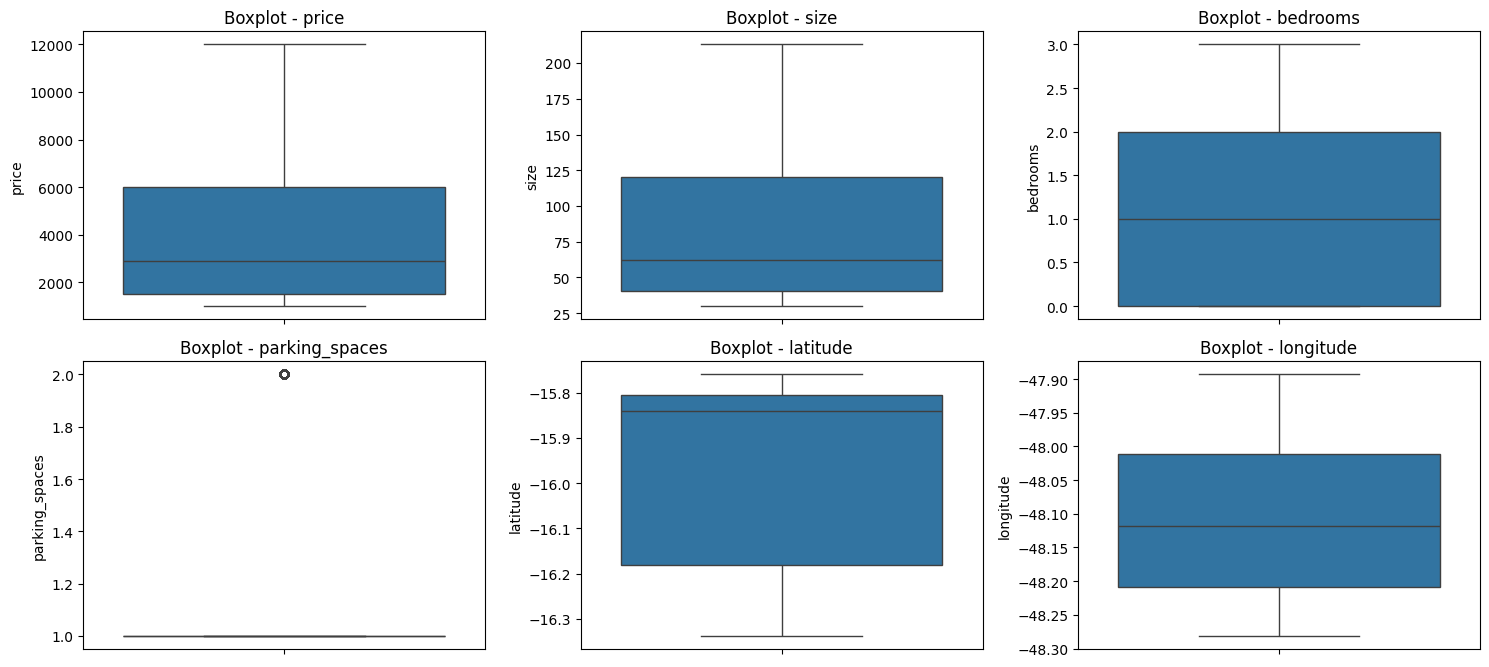

In [454]:
# Tratamento de Outliers em todas as colunas numéricas
numeric_columns = df.select_dtypes(include=['number']).columns

for col in numeric_columns:
    print(f"Tratando outliers na coluna: {col}")
    
    # Calcular os percentis 10 e 90
    tenth_percentile = np.percentile(df[col], 10)
    ninetieth_percentile = np.percentile(df[col], 90)
    
    # Aplicar flooring e capping
    df[col] = np.where(df[col] < tenth_percentile, tenth_percentile, df[col])
    df[col] = np.where(df[col] > ninetieth_percentile, ninetieth_percentile, df[col])
    
    print(f"Outliers tratados na coluna {col}. Valores abaixo de {tenth_percentile} foram substituídos por {tenth_percentile}, e valores acima de {ninetieth_percentile} foram substituídos por {ninetieth_percentile}.")

# Visualização dos boxplots após o tratamento de outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot - {col}")
    plt.tight_layout()

plt.show()

## Modelo Random Forest

*Ref:*

1 - https://www.datacamp.com/tutorial/random-forests-classifier-python

In [455]:
# Modelo de Random Forest para prever o preço dos imóveis

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Separar as features (X) e o target (y)
if 'price' in df.columns:
    X = df.drop(columns=['price'])  # Remover a coluna target
    y = df['price']  # Definir a coluna target

    # Garantir que todas as features sejam numéricas
    X = pd.get_dummies(X, drop_first=True)

    # treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modelo
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    rf_model.fit(X_train, y_train)

    # Prev em teste
    y_pred = rf_model.predict(X_test)

    # Avaliação
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R² Score: {r2}")

    # # Exibir a importância das features
    # feature_importances = pd.DataFrame({
    #     'Feature': X.columns,
    #     'Importance': rf_model.feature_importances_
    # }).sort_values(by='Importance', ascending=False)

    # # print("\nImportância das Features:")
    # # print(feature_importances)
else:
    print("A coluna 'price' não está presente no DataFrame.")

Mean Absolute Error (MAE): 644.0701638822311
Mean Squared Error (MSE): 1751593.5090749816
R² Score: 0.8412276961368019


In [456]:
df['price'].mean()

4341.416303917689

## Conclusão
Com base nos resultados obtidos, o modelo apresentou um MAE de 644, o que representa um erro médio de aproximadamente 15% em relação à média de preço (4331). O R² de 0.84 indica que o modelo explica bem a variância dos dados, mas ainda pode melhorar 

Para melhorar, podemos ajustar os hiperparâmetros do Random Forest, realizar uma análise mais profunda das features para eliminar irrelevantes ou criar novas variáveis, e tratar melhor os outliers.

*Refs:*

1 - https://www.geeksforgeeks.org/regression-metrics/